<a href="https://colab.research.google.com/github/krajak09/Master-Thesis/blob/main/scripts/FilterRandomWalk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
%pip install filterpy

In [29]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
import numpy as np
import scipy.stats as stats
import scipy.optimize as opt
import matplotlib.pyplot as plt

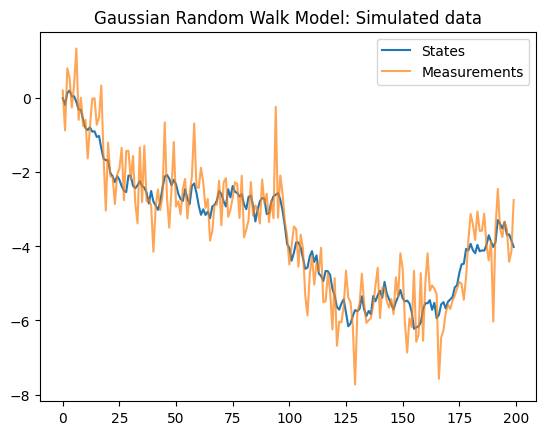

In [30]:
# simulate a gaussian random walk series

# variances
sigma2_q = 0.05 # state noise variance
sigma2_r = 0.5 # observation noise variance

T = 200

x = np.zeros(T)
y = np.zeros(T)

sigma_q = np.sqrt(sigma2_q)
sigma_r = np.sqrt(sigma2_r)

for t in range(1,T):
  x[t] = x[t-1] + stats.norm.rvs(loc=0.0, scale=sigma_q)

y = x + stats.norm.rvs(loc=0.0, scale=sigma_r, size=T)

plt.plot(x, label='States')
plt.plot(y, label='Measurements', alpha=0.7)
plt.legend()
plt.title('Gaussian Random Walk Model: Simulated data')
plt.show()

State: $$x_t = x_{t-1}+ q_t,$$

$q_t \sim N(0, Q)$

State transition matrix: $$F=\begin{bmatrix} 1\end{bmatrix}$$

Observation matrix: $$H=\begin{bmatrix} 1\end{bmatrix}$$

Measurement function: $$y_t = Hx_t+r_t,$$
$r_t \sim N(0,R)$



In [31]:
x0=0.0
P0=1.0

In [32]:
def filter_random_walk(y, sigma2_q, sigma2_r, x0, P0):
  f = KalmanFilter (dim_x=1, dim_z=1)

  f.x = np.array([[x0]])

  f.F = np.array([[1.0]])
  f.H = np.array([[1.0]])

  # Initial covariance
  f.P = np.array([[P0]])

  # Process Noise
  f.Q = np.array([[sigma2_q]])
  f.R = np.array([[sigma2_r]])

  filtered_state = []
  filtered_obs = []

  for z in y:
    f.predict()
    f.update(z)
    filtered_state.append(f.x)
    filtered_obs.append(f.measurement_of_state(f.x))

  return filtered_state, filtered_obs

In [33]:
def predict_random_walk(y, sigma2_q, sigma2_r, x0, P0):
  f = KalmanFilter (dim_x=1, dim_z=1)

  f.x = np.array([[x0]])

  f.F = np.array([[1.0]])
  f.H = np.array([[1.0]])

  # Initial covariance
  f.P = np.array([[P0]])

  # Process Noise
  f.Q = np.array([[sigma2_q]])
  f.R = np.array([[sigma2_r]])

  mse_total = 0.0
  error_list = []

  for z in y:
    f.predict()
    mse = (f.measurement_of_state(f.x) - z)**2

    error_list.append(mse)
    mse_total += mse

    f.update(z)
  return mse_total, error_list

In [34]:
def make_energy_random_walk(y, x0, P0):

  def energy_fun(theta):
    log_sigma2_q = theta[0]
    log_sigma2_r = theta[1]
    sigma2_q = np.exp(log_sigma2_q) #sigma needs to be non-negative
    sigma2_r = np.exp(log_sigma2_r) #sigma needs to be non-negative

    f = KalmanFilter (dim_x=1, dim_z=1)

    f.x = np.array([[x0]])

    f.F = np.array([[1.0]])
    f.H = np.array([[1.0]])

    # Initial covariance
    f.P = np.array([[P0]])

    # Process Noise
    f.Q = np.array([[sigma2_q]])
    f.R = np.array([[sigma2_r]])

    score = 0.0

    for z in y:
      f.predict()
      f.update(z)
      score += f.log_likelihood
    return -score

  return energy_fun

In [35]:
energy_fun = make_energy_random_walk(y, x0=0.0, P0=1.0)

In [36]:
theta0 = np.array([1.0,1.0,np.log(0.1)])
res = opt.minimize(energy_fun, theta0)

In [37]:
def fit_and_predict_random_walk(y, x0, P0):
  # Fit maximum likelihood
  energy_fun = make_energy_random_walk(y, x0=0.0, P0=1.0)
  theta0 = np.array([0.0,0.0,np.log(1.0)])
  res = opt.minimize(energy_fun, theta0)

  # Compute MSE for fitted model
  log_sigma2_q = res.x[0]
  log_sigma2_r = res.x[1]
  sigma2_q = np.exp(log_sigma2_q)
  sigma2_r = np.exp(log_sigma2_r)

  mse, error_list = predict_random_walk(y, sigma2_q, sigma2_r, x0, P0)
  filtered_states, filtered_obs = filter_random_walk(y, sigma2_q, sigma2_r, x0, P0)

  return res, mse, error_list, filtered_states, filtered_obs

In [38]:
res, mse, error_list, filtered_states, filtered_obs = fit_and_predict_random_walk(y, x0, P0)

/tmp/ipython-input-1930948908.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fitted_y = np.array([float(v) for v in filtered_obs])
/tmp/ipython-input-1930948908.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  errors = [float(e) for e in error_list]


Text(0.5, 1.0, 'Gaussian Random Walk: States vs. Fitted')

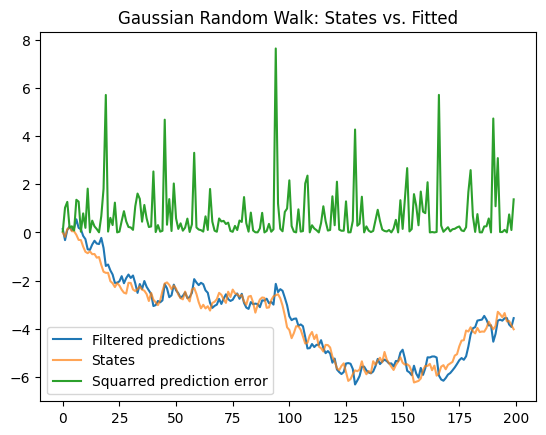

In [40]:
# Fitted model
fitted_y = np.array([float(v) for v in filtered_obs])
errors = [float(e) for e in error_list]

plt.plot(fitted_y, label='Filtered predictions')
plt.plot(x, label='States', alpha=0.7)
plt.plot(errors, label='Squarred prediction error')
plt.legend()
plt.title('Gaussian Random Walk: States vs. Fitted')